数据集地址：https://www.kaggle.com/datasets/burak3ergun/loan-data-set  
二分类任务，使用卡方检验进行特征筛选，使用逻辑回归对是否贷款即数据集中的Loan_Status进行预测

In [30]:
import pandas as pd



# 读取文件，并将贷款时间和信用历史由数值型转为分类类型，然后得到除目标列的分类列名

In [34]:
loan = pd.read_csv('datasets\loan_data_set.csv')
#loan.info()
loan.drop('Loan_ID',axis=1,inplace=True)
#loan.info()
loan['Loan_Amount_Term']=loan['Loan_Amount_Term'].astype('object')
loan['Credit_History']=loan['Credit_History'].astype('object')
loan.dropna(inplace=True)
categorical_columns = loan.select_dtypes(exclude=['number']).drop('Loan_Status',axis=1).columns
print(categorical_columns)
loan.info()


Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 1 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             480 non-null    object 
 1   Married            480 non-null    object 
 2   Dependents         480 non-null    object 
 3   Education          480 non-null    object 
 4   Self_Employed      480 non-null    object 
 5   ApplicantIncome    480 non-null    int64  
 6   CoapplicantIncome  480 non-null    float64
 7   LoanAmount         480 non-null    float64
 8   Loan_Amount_Term   480 non-null    object 
 9   Credit_History     480 non-null    object 
 10  Property_Area      480 non-null    object 
 11  Loan_Status        480 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 48.8+ KB


In [4]:
pd.crosstab(loan["Gender"],loan['Loan_Status'])     #性别和贷款状态交叉表

Loan_Status,N,Y
Gender,,
Female,32,54
Male,116,278


In [5]:
from scipy.stats import chi2_contingency
chi_res = chi2_contingency(pd.crosstab(loan['Gender'],loan['Loan_Status']))
print(chi_res)                                #第一个值是卡方值，第二个值是p值，第三个值是自由度，第四个是期望值
print("卡方值:{}\n  p值:{}".format(chi_res[0],chi_res[1]))

(1.6495637942018448, 0.1990183114281211, 1, array([[ 26.51666667,  59.48333333],
       [121.48333333, 272.51666667]]))
卡方值:1.6495637942018448
  p值:0.1990183114281211


# 对所有的列于目标列进行卡方检验

In [6]:
chi2_check = []
for i in categorical_columns:
    if chi2_contingency(pd.crosstab(loan['Loan_Status'],loan[i]))[1] < 0.05:
        chi2_check.append('Reject H0')
    else:
        chi2_check.append('Accept H0')
print(chi2_check)
res = pd.DataFrame(data=[categorical_columns,chi2_check]).T
res.columns = ['Column','H0']
print(res)

['Accept H0', 'Reject H0', 'Accept H0', 'Accept H0', 'Accept H0', 'Reject H0', 'Reject H0', 'Reject H0']
             Column         H0
0            Gender  Accept H0
1           Married  Reject H0
2        Dependents  Accept H0
3         Education  Accept H0
4     Self_Employed  Accept H0
5  Loan_Amount_Term  Reject H0
6    Credit_History  Reject H0
7     Property_Area  Reject H0


独立性的卡方检验是一种总括检验，即对数据进行整体检验。如果一个类别中有多个类别，如果卡方表大于 2×2，
我们就无法轻易判断是哪个类别的特征造成了这种关系。要确定是哪一类造成了这种关系，我们需要进行事后检验。

In [7]:
property_dummies = pd.get_dummies(data = loan[['Property_Area']],columns=['Property_Area'])
print(property_dummies.head())
property_dummies = pd.concat([property_dummies,loan['Loan_Status']],axis=1)
property_dummies.head()
chi_res = chi2_contingency(pd.crosstab(property_dummies['Property_Area_Rural'],property_dummies['Loan_Status']))
print(chi_res)


   Property_Area_Rural  Property_Area_Semiurban  Property_Area_Urban
1                    1                        0                    0
2                    0                        0                    1
3                    0                        0                    1
4                    0                        0                    1
5                    0                        0                    1
(5.377420967206426, 0.02039901197579578, 1, array([[105.14166667, 235.85833333],
       [ 42.85833333,  96.14166667]]))


计算每列的不同分类与目标列的卡方检验的p值，由于初始值为0.05，对多个类别的每次测试都会增加误差，第二次误差为0.1，第三次为0.15，
所以需要进行矫正，初始0.05除去检测次数

In [8]:
check = {}
for i in res[res['H0'] == 'Reject H0']['Column']:
    dummies = pd.get_dummies(loan[i])
    bon_p_value = 0.05/loan[i].nunique()        #卡方检测的p值矫正
    for j in dummies.columns:
        if chi2_contingency(pd.crosstab(dummies[j],loan['Loan_Status']))[1] < bon_p_value:
            check['{}-{}'.format(i,j)] = 'Reject H0'
        else:
            check['{}-{}'.format(i,j)] = 'Accept H0'
res_chi_ph = pd.DataFrame(data = [check.keys(),check.values()]).T
res_chi_ph.columns = ['Column','H0']
print(res_chi_ph)
   

                     Column         H0
0                Married-No  Reject H0
1               Married-Yes  Reject H0
2     Loan_Amount_Term-36.0  Accept H0
3     Loan_Amount_Term-60.0  Accept H0
4     Loan_Amount_Term-84.0  Accept H0
5    Loan_Amount_Term-120.0  Accept H0
6    Loan_Amount_Term-180.0  Accept H0
7    Loan_Amount_Term-240.0  Accept H0
8    Loan_Amount_Term-300.0  Accept H0
9    Loan_Amount_Term-360.0  Accept H0
10   Loan_Amount_Term-480.0  Accept H0
11       Credit_History-0.0  Reject H0
12       Credit_History-1.0  Reject H0
13      Property_Area-Rural  Accept H0
14  Property_Area-Semiurban  Reject H0
15      Property_Area-Urban  Accept H0


c:\Users\momo\anaconda3\envs\py39-TS\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
c:\Users\momo\anaconda3\envs\py39-TS\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


使用逻辑回归进行预测，使用所有的特征进行预测

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
data_log = pd.get_dummies(data=loan,columns=loan.select_dtypes(exclude=['int64','float64']).drop('Loan_Status',axis=1).columns,drop_first=True)
data_log.head()
data_log['Loan_Status'] = data_log['Loan_Status'].map({'Y':1,'N':0})
data_log.head()
X_train,X_test,y_train,y_test = train_test_split(data_log.drop('Loan_Status',axis=1),data_log['Loan_Status'],test_size=0.3,random_state=1234)
#print(X_train.head())
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train,y_train)
predictions = log_model.predict(X_test)
print(accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))



     ApplicantIncome  CoapplicantIncome  LoanAmount  Gender_Male  Married_Yes  \
136             4583                0.0        84.0            0            1   
201             4923                0.0       166.0            1            0   
519             3400                0.0        95.0            0            0   
46              5649                0.0        44.0            1            1   
180             6400             7250.0       180.0            1            1   

     Dependents_1  Dependents_2  Dependents_3+  Education_Not Graduate  \
136             0             0              0                       0   
201             0             1              0                       0   
519             0             0              0                       1   
46              1             0              0                       0   
180             1             0              0                       0   

     Self_Employed_Yes  ...  Loan_Amount_Term_84.0  Loan_Amount_Term

c:\Users\momo\anaconda3\envs\py39-TS\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


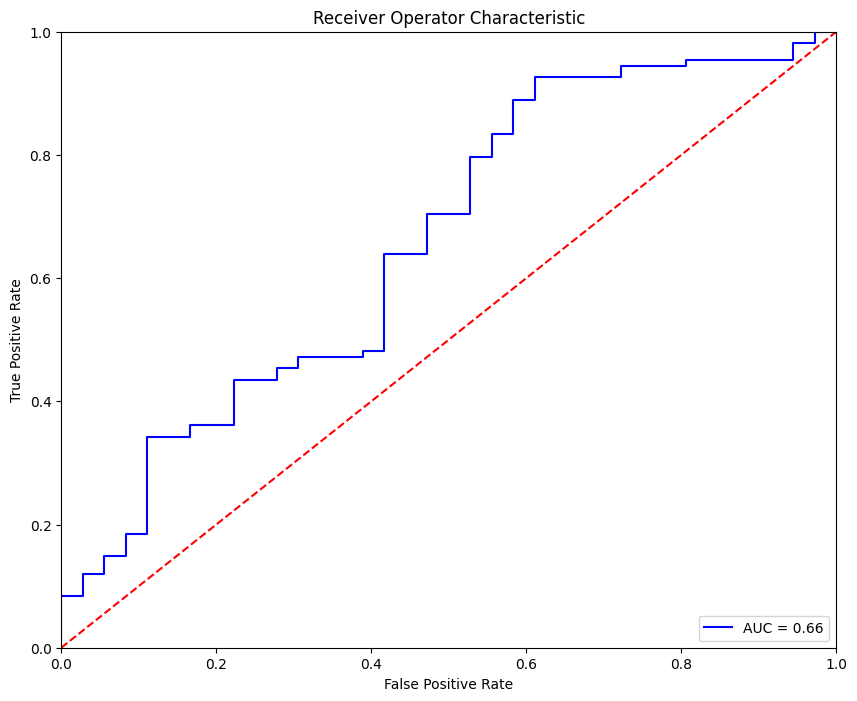

In [21]:
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve
preds = log_model.predict_proba(X_test)[:,1]            #函数返回每个类别的样本概率（n_samples，n_classes）
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)                                   #计算AUC值
plt.figure(figsize=(10,8))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


进行特征筛选，只保留卡方检验后留下的特征

In [24]:

significant_chi = []
for i in res_chi_ph[res_chi_ph['H0'] == 'Reject H0']['Column']:    
 significant_chi.append('{}_{}'.format(i.split('-')[0],i.split('-')[1]))

for i in ['Married_No', 'Credit_History_0.0']:    
 significant_chi.remove(i)

for i in loan.select_dtypes('number').columns:
 significant_chi.append(i)
print(significant_chi)

['Married_Yes', 'Credit_History_1.0', 'Property_Area_Semiurban', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [28]:
log_model = LogisticRegression(max_iter = 1000)
log_model.fit(X_train[significant_chi], y_train)
print(X_train[significant_chi].head())
predictions = log_model.predict(X_test[significant_chi])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))

     Married_Yes  Credit_History_1.0  Property_Area_Semiurban  \
136            1                   1                        0   
201            0                   0                        1   
519            0                   1                        0   
46             1                   1                        0   
180            1                   0                        0   

     ApplicantIncome  CoapplicantIncome  LoanAmount  
136             4583                0.0        84.0  
201             4923                0.0       166.0  
519             3400                0.0        95.0  
46              5649                0.0        44.0  
180             6400             7250.0       180.0  
0.8125
              precision    recall  f1-score   support

           0       0.85      0.31      0.45        36
           1       0.81      0.98      0.89       108

    accuracy                           0.81       144
   macro avg       0.83      0.64      0.67       144
weight

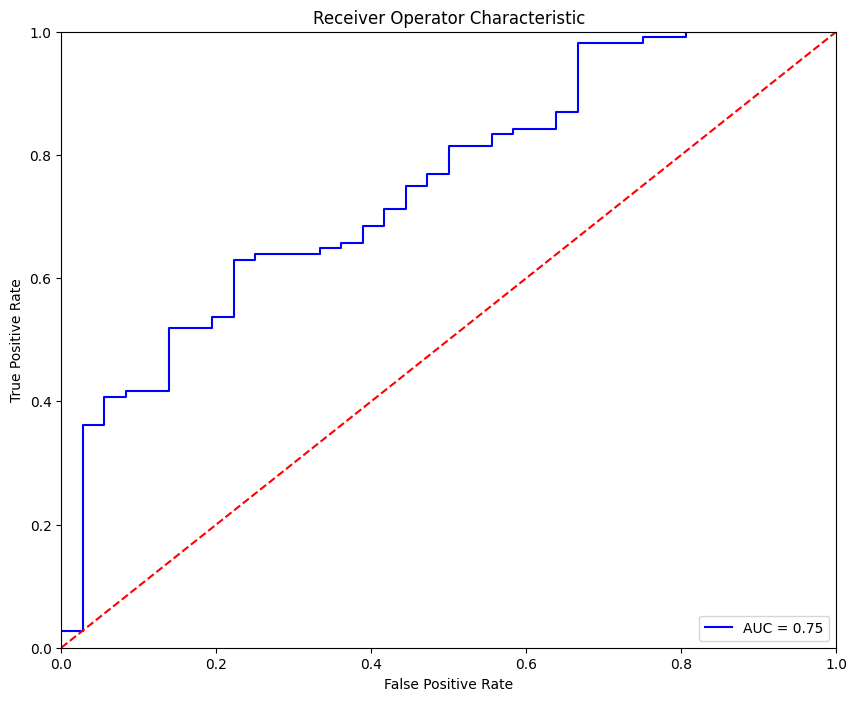

In [29]:
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve
preds = log_model.predict_proba(X_test[significant_chi])[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
